In [1]:
import os, sys
import healpy as hp
import numpy as np

sys.path.append('../../')
sys.path.append('/DMASS-analysis/measurements/code_py3/')

import esutil
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from utils import *

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

os.chdir('/users/PCON0003/warner785/DMASS-analysis/measurements/code_py3/')
print(os.getcwd())

from calling_catalogs import *
from sys_functions import *

rootdir = '/users/PCON0003/warner785/DMASS-analysis/measurements/clustering/'

from ggl_mcal import run_ng_jk, run_nn_jk, run_nk_jk, compute_eix_jk, compute_Rgamma_jk, construct_jk, compute_jkcov, save_results

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


/users/PCON0003/warner785/DMASS-analysis/measurements/code_py3


In [3]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

In [37]:
# for checking maps

sysMap = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/PCA/extinction/ebv_sfd98_fullres_nside_4096_nest_equatorial_des.fits.gz')
f = fitsio.FITS('/fs/scratch/PCON0008/warner785/bwarner/PCA/extinction/ebv_sfd98_fullres_nside_4096_nest_equatorial_des.fits.gz')
h = f[-1].read_header()
print(h)

print(sysMap.shape)
#flat = sysMap['I'].flatten()
#print(flat.shape)
print(hp.visufunc.mollview(sysMap['SIGNAL']))

In [3]:
# for dmass spt

dmass_spt = calling_catalog('/fs/scratch/PCON0008/warner785/bwarner/dmass_spt.fits')
random_spt = uniform_random_on_sphere(dmass_spt, size = 10*int(np.sum(dmass_spt['CMASS_PROB']))) 
random_spt = keepGoodRegion(random_spt)
random_spt = appendColumn(random_spt, value=np.ones(random_spt.size), name='CMASS_PROB')
index_mask = np.argsort(dmass_spt)
dmass_chron = dmass_spt[index_mask] # ordered by hpix values

Resulting catalog size
DMASS= 341117.6414259936


In [4]:
quad_weight = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/june23_tests/'+'iterative50.fits')
lin_weight = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/june23_tests/'+'linchi2_50.fits')

qweights = dmass_chron["CMASS_PROB"]*quad_weight
lweights = dmass_chron["CMASS_PROB"]*lin_weight

In [7]:
# load in CMASS later:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/matched_cmass.fits')

print(cmass.size)

60037


In [2]:
# checking y1 dmass:
y1_dmass = calling_catalog('/fs/scratch/PCON0008/warner785/bwarner/dmass_y1_public_v1.fits')
randoms = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/random_dmass_y1_public_v1.fits')

Resulting catalog size
DMASS= 117292.90214602613


In [3]:
randoms = appendColumn(randoms, value=np.ones(randoms.size), name='CMASS_PROB')

In [8]:
print(y1_dmass.dtype.names)

('COADD_OBJECTS_ID', 'RA', 'DEC', 'VETO', 'CMASS_PROB', 'WEIGHT_SYS')


In [8]:
randomsind_create = np.random.choice( random_create.size, size=int(random_create.size/3.) )
random_create = random_create[randomsind_create]

In [4]:
def treecorr_xi(lens, random=None, filename=None, rootdir=None, 
		nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.05, 
        npatch=10, var_method='jackknife', cen_file = None, w = None):
    
    import treecorr

    if cen_file != None:
        if os.path.exists(cen_file):
            print ('Saved cen_file exists:',cen_file)
            cen_file_switch_on = cen_file
            npatch=1
        else : 
            print ('Create cen_file=',cen_file)
            cen_file_switch_on = None

    #temp_dir=filename.split('.txt')[0]
    cat_l = treecorr.Catalog(ra=lens['RA'], dec=lens['DEC'], w=lens['CMASS_PROB']*lens['WEIGHT_SYS'], 
                             ra_units='deg', dec_units='deg', npatch=npatch, 
                             patch_centers=cen_file_switch_on )

    if cen_file_switch_on == None : 
        cat_l.write_patch_centers(cen_file)
#changed to make weights = 1 for randoms
    #from numpy.lib.recfunctions import append_fields
    #weights = np.zeros(len(random))
    #for x in range(len(random)-1):
        #weights[x]=1
    #random = append_fields(random, 'WEIGHT', weights, usemask=False)
    
    cat_r = treecorr.Catalog(ra=random['RA'], dec=random['DEC'], w=random['CMASS_PROB'], 
                             ra_units='deg', dec_units='deg', 
                             patch_centers=cen_file_switch_on )
    
    dd = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                            max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                            var_method=var_method,
                            num_threads=30, verbose=1)
    dr = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)
    rd = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)
    rr = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)

    dd.process(cat_l)
    dr.process(cat_l, cat_r)
    rd.process(cat_r, cat_l)
    rr.process(cat_r)
    xi,varxi = dd.calculateXi(rr,dr)
    dd.write(filename,rr,dr,rd)
    
    cov_jk = dd.estimate_cov(var_method)
    cov_filename=filename.split('.txt')[0]+'.cov'
    np.savetxt(cov_filename, cov_jk)
    
    print ('save to', filename)
    
# search for VETO in run_DMASS
# ask Su about this, if not

In [5]:
npatch=80
tempdir = rootdir+'/{}/'.format(npatch)
cen_file = tempdir + 'nn_cen_file_y1.txt'
filename = tempdir + 'nn.lens_y1.txt'

#os.system('mkdir '+savedir)
#print (os.path.exists(tempdir) )
os.system('rm -rf '+tempdir)
os.system('mkdir '+tempdir)

# default of poisson errors -- try this
# ***save to different variables to compare different methods of errors

treecorr_xi(y1_dmass, random=randoms,
        filename=filename, rootdir = tempdir, 
        nbins=20, min_sep=2.5, max_sep=250., sep_units='arcmin', bin_slop=0.05,
        npatch=npatch, cen_file=cen_file, var_method='jackknife', w = y1_dmass['CMASS_PROB']*y1_dmass['WEIGHT_SYS'])

cov_quad_dmass= np.genfromtxt(tempdir+'/nn.lens_y1.cov'.format(npatch))
_, meanr, _, galaxy_xi, xi_err,_,_,_,_,_ = np.genfromtxt(tempdir+'nn.lens_y1.txt'.format(npatch), unpack=True)

Create cen_file= /users/PCON0003/warner785/DMASS-analysis/measurements/clustering//80/nn_cen_file_y1.txt


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/treecorr/util.py:669: FutureWarning: Use of keyword-only arguments as positional arguments is deprecated in the function calculateXi. The following parameters now require an explicit keyword name: ['rr', 'dr']
  str(kw_names), FutureWarning)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/treecorr/util.py:669: FutureWarning: Use of keyword-only arguments as positional arguments is deprecated in the function write. The following parameters now require an explicit keyword name: ['rr', 'dr', 'rd']
  str(kw_names), FutureWarning)


save to /users/PCON0003/warner785/DMASS-analysis/measurements/clustering//80/nn.lens_y1.txt


In [7]:
npatch=80
tempdir = rootdir+'/{}/'.format(npatch)
cen_file = tempdir + 'nn_cen_file_lin.txt'
filename = tempdir + 'nn.lens_lin.txt'

#os.system('mkdir '+savedir)
#print (os.path.exists(tempdir) )
os.system('rm -rf '+tempdir)
os.system('mkdir '+tempdir)

# default of poisson errors -- try this
# ***save to different variables to compare different methods of errors

treecorr_xi(dmass_chron, random=random_spt,
        filename=filename, rootdir = tempdir, 
        nbins=20, min_sep=2.5, max_sep=250., sep_units='arcmin', bin_slop=0.05,
        npatch=npatch, cen_file=cen_file, var_method='jackknife', w = lweights*dmass_chron['CMASS_PROB'])

cov_lin_dmass= np.genfromtxt(tempdir+'/nn.lens_lin.cov'.format(npatch))
_, meanr_lin, _, galaxy_xi_lin, xi_err_lin,_,_,_,_,_ = np.genfromtxt(tempdir+'nn.lens_lin.txt'.format(npatch), unpack=True)

save to /users/PCON0003/warner785/DMASS-analysis/measurements/clustering//80/nn.lens_lin.txt


In [8]:
# read in Su's data:

wtheta_su = np.array([[2.80504614e+00, 2.04160000e-01],
 [3.53134386e+00, 1.71170000e-01],
 [4.44569853e+00, 1.47430000e-01],
 [5.59680285e+00, 1.25550000e-01],
 [7.04595733e+00, 1.05600000e-01],
 [8.87033473e+00, 8.70390000e-02],
 [1.11670898e+01, 7.65390000e-02],
 [1.40585331e+01, 6.24190000e-02],
 [1.76986446e+01, 5.21800000e-02],
 [2.22812735e+01, 4.21460000e-02],
 [2.80504614e+01, 3.38060000e-02],
 [3.53134386e+01, 2.75830000e-02],
 [4.44569853e+01, 2.07170000e-02],
 [5.59680285e+01, 1.57440000e-02],
 [7.04595733e+01, 1.27630000e-02],
 [8.87033473e+01, 9.31180000e-03],
 [1.11670898e+02, 6.26490000e-03],
 [1.40585331e+02, 3.96460000e-03],
 [1.76986446e+02, 2.31330000e-03],
 [2.22812735e+02, 6.60470000e-04]])

In [19]:
print(wtheta_su[0][1])
print(wtheta_su.shape)

0.20416
(20, 2)


In [21]:
meanr_su = []
galaxy_xi_su = []
for x in range(20):
    meanr_su.append(wtheta_su[x,0])
    galaxy_xi_su.append(wtheta_su[x,1])

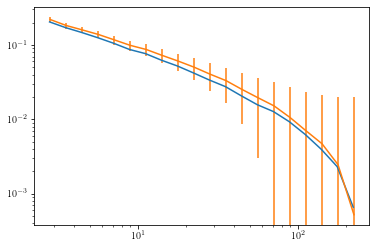

In [23]:
fig, ax = plt.subplots()

#ax.loglog(theta, galaxy_xi_theory)
ax.errorbar( meanr_su, galaxy_xi_su)
#ax.errorbar( meanr, galaxy_xi_lin-galaxy_xi, xi_err )
ax.errorbar( meanr, galaxy_xi, xi_err)
ax.set_xscale('log')
ax.set_yscale('log')

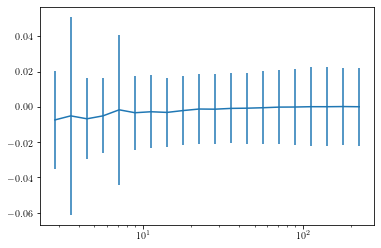

In [14]:
# difference of dmass with and without prob cut

fig, ax = plt.subplots()

ax.errorbar( meanr, (galaxy_xi-galaxy_xi_cut), xi_err )
ax.set_xscale('log')

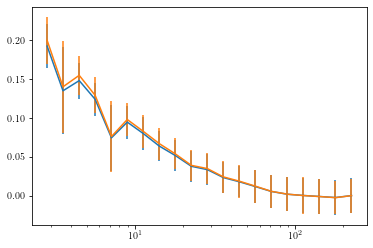

In [15]:
# difference of dmass with and without prob cut

fig, ax = plt.subplots()

ax.errorbar( meanr, galaxy_xi, xi_err )
ax.errorbar( meanr_cut, galaxy_xi_cut, xi_err_cut )
ax.set_xscale('log')